Name: Niall Tierney
Student Number: 18200044
Dataset: https://www.kaggle.com/jacobbaruch/nba-player-of-the-week/version/1

In [318]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,  cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [309]:
path = "NBA_player_of_the_week.csv"

#load .csv file
df = pd.read_csv(path)
#print the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 13 columns):
Age                  1145 non-null int64
Conference           761 non-null object
Date                 1145 non-null object
Draft Year           1145 non-null int64
Height               1145 non-null object
Player               1145 non-null object
Position             1145 non-null object
Season               1145 non-null object
Season short         1145 non-null int64
Seasons in league    1145 non-null int64
Team                 1145 non-null object
Weight               1145 non-null object
Real_value           1145 non-null float64
dtypes: float64(1), int64(4), object(8)
memory usage: 116.4+ KB


In [310]:
df.head()

,Age,Conference,Date,Draft Year,Height,Player,Position,Season,Season short,Seasons in league,Team,Weight,Real_value
0,29,NaN,"Apr 14, 1985",1978,6-5,Micheal Ray Richardson,PG,1984-1985,1985,6,New Jersey Nets,189,1.0
1,23,NaN,"Apr 7, 1985",1982,6-6,Derek Smith,SG,1984-1985,1985,2,Los Angeles Clippers,205,1.0
2,28,NaN,"Apr 1, 1985",1979,6-6,Calvin Natt,F,1984-1985,1985,5,Denver Nuggets,220,1.0
3,37,NaN,"Mar 24, 1985",1969,7-2,Kareem Abdul-Jabbar,C,1984-1985,1985,15,Los Angeles Lakers,225,1.0
4,28,NaN,"Mar 17, 1985",1978,6-9,Larry Bird,SF,1984-1985,1985,5,Boston Celtics,220,1.0


In [311]:
#i will only keep the columns which i think are the most important in the dataset
columns_to_keep = ["Age", "Height", "Position", "Seasons in league", "Team", "Weight", "Real_value"]
#filter the dataframe and keep only the specific columns
df = df[columns_to_keep]
df.head()

,Age,Height,Position,Seasons in league,Team,Weight,Real_value
0,29,6-5,PG,6,New Jersey Nets,189,1.0
1,23,6-6,SG,2,Los Angeles Clippers,205,1.0
2,28,6-6,F,5,Denver Nuggets,220,1.0
3,37,7-2,C,15,Los Angeles Lakers,225,1.0
4,28,6-9,SF,5,Boston Celtics,220,1.0


Some values on the height column are expressed as feet and others as cm (example values: "7-2", "203cm")
I parse all the rows of this column and i convert each value into cms. <br>

The values of the weight column are expressed as kg. Some rows have also the "kg" word which must be removed. Each row of this column is converted into kg. <br>

The target variable which is the column "Real_value" takes values 0.5 or 1.0. I replace each occurence of 0.5 with 0.0 and each occurence of 1.0 with 1.0. <br>

Finally the columns are normalized into the range [0,1] by dividing each column with the maximum of the corresponding column

In [312]:
height_in_cm = []
for i in range(len(df["Height"])):
    if "cm" in df["Height"][i]:
        #remove 'cm' word and convert it into float
        height_in_cm.append(float(df["Height"][i].replace("cm", "")))
    else:
        #replace "-" with "." and make it float. Then convert the feet
        #into cm by multiplying with 30.48
        feet = float(df["Height"][i].replace("-", "."))
        height_in_cm.append(round(feet * 30.48))

#update height column with the new values
df["Height"] = height_in_cm

weight_in_kg = []
for i in range(len(df["Weight"])):
    if "kg" in df["Weight"][i]:
        #remove the 'kg' word
        weight_in_kg.append(float(df["Weight"][i].replace("kg", "")))
    else:
         weight_in_kg.append(float(df["Weight"][i]))      

#update the weight column with the new values
df["Weight"] = weight_in_kg
            
#normalize Age, Height, Seasons in league and weight columns dividing with with max of each column
df["Age"] = df["Age"]/df["Age"].max()
df["Height"] = df["Height"]/df["Height"].max()
df["Seasons in league"] = df["Seasons in league"]/df["Seasons in league"].max()
df["Weight"] = df["Weight"]/df["Weight"].max()

#replace 0.5 with 0.0 and 1.0 with 1.0 on the Real_values column
real_value_mapping = {0.5: 0.0, 1.0: 1.0}
df.Real_value = [real_value_mapping[item] for item in df.Real_value]

df.head()

print ("Zeros: {}, Ones: {}".format(len(df[df["Real_value"] == 0.0]), (len(df[df["Real_value"] == 1.0]))))

Zeros: 761, Ones: 384


When using SVM classifier it's suggested to encode the categorical data using the onehot encode technique. In this case we have two categorical columns, the position and the team. I've used onehot encoding on these data having as reference the code in https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/. First the integer encoding is calculating and then the onehot encoding. After the calculation each column is added into the dataframe.

In [313]:
#we have two categorical columns
columns_to_encode = ["Position", "Team"]

for col in columns_to_encode:
    data = df[col]
    values = array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    #add each column into the dataframe
    for i in range(onehot_encoded.shape[1]):
        df[col + str(i)] = onehot_encoded[...,i].tolist()
        
#drop the two categorical columns. Now we have the proper encoded information
df = df.drop(columns=columns_to_encode)
df.head()

,Age,Height,Seasons in league,Weight,Real_value,Position0,Position1,Position2,Position3,Position4,...,Team25,Team26,Team27,Team28,Team29,Team30,Team31,Team32,Team33,Team34
0,0.725,0.853448,0.352941,0.581538,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.575,0.866379,0.117647,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.700,0.866379,0.294118,0.676923,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925,0.943966,0.882353,0.692308,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.700,0.905172,0.294118,0.676923,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the below cell the SVM training is implemented. The data contains 761 rows with Real_value = 0 and 384 rows with Real_value = 1. To make the training more balanced i choose for each validation the 20% of class 0 as testing while only the 10% of the class 1 as testing. I perform 'LOOPS' cross validations and i calculate the mean accuracy and the mean confusion matrix.

In [341]:
#all column names
column_names = set(df.columns.values)
#target column
target = set(["Real_value"])
#feature columns
features = list(column_names.difference(target))
target = list(target)[0]
#number of cross validations
LOOPS = 100

#rows of dataframe where Real_value = 0.0
zeros = df[df[target] == 0.0]
#rows of dataframe where Real_value == 1.0
ones = df[df[target] == 1.0]
#create SVM instance
clf = svm.SVC()

mean_accuracy = 0.0
mean_confusion_matrix = np.zeros((2,2)).astype("float")

for i in range(LOOPS):
    #choose randomly 20% of zeros as testing while the rest goes for training
    train0, test0 = train_test_split(zeros, test_size=0.20, shuffle=True)
    #choose randomly 10% of ones as testing while the rest goes for training
    train1, test1 = train_test_split(ones, test_size=0.10, shuffle=True)
    #concatenate the results
    train =  pd.concat([train0, train1])
    test = pd.concat([test0, test1])
    
    #make the prediction
    y = train[target]
    X = train[features]
    clf.fit(X, y)  
    y_pred = clf.predict(test[features])
    y_true = test[target]
    
    #calculate the accuracy
    accuracy = accuracy_score(y_true,y_pred)*100
    accuracy = round(accuracy, 5)
    mean_accuracy += accuracy
    
    #calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    mean_confusion_matrix = mean_confusion_matrix + cm
    
#calculate mean accuracy and mean confusion matrix
mean_accuracy /= LOOPS
mean_confusion_matrix /= LOOPS
mean_confusion_matrix = np.round(mean_confusion_matrix).astype("int")

#print proper messages
print ("Loops: {}, Mean accuracy: {}".format(LOOPS, mean_accuracy))
print ("===MEAN CONFUSION MATRIX===")
print (mean_confusion_matrix)

Loops: 100, Mean accuracy: 77.1197913
===MEAN CONFUSION MATRIX===
[[138  15]
 [ 29  10]]


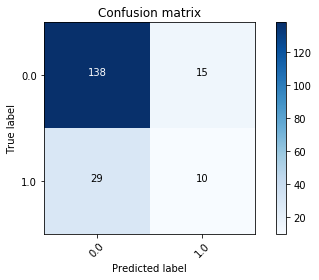

In [342]:
#plot the confusion matrix
plt.figure()
plot_confusion_matrix(mean_confusion_matrix, classes=["0.0", "1.0"])

Looking at the confusion matrix it's more clear why we have such a low accuracy. The classifier fails to predict correctly most of the rows of class '1.0'. This happens because the dataset is not well balanced and the elements of class '0.0' are much more than the elements of class '1.0'.